In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
import jax.numpy as jnp

jnp.array(1.)
print("Available devices:", jax.devices())

Available devices: [CudaDevice(id=0)]


In [2]:
import dataset_util

tokenized_examples, labels, vocabulary, inverse_vocabulary = dataset_util.main(max_length=25,
                                                                  seed=0,
                                                                  root_dir="KGDatasets/Kinship",
                                                                  split="train")
tokenized_examples, labels

Sample of generated dataset:
Example 1: 1 4 39 5 25 6 94 3 0 0...
         (Original: [CLS] Is person65 the term8 of person8 ? | Label: 1)
Example 2: 1 4 109 5 20 6 60 3 0 0...
         (Original: [CLS] Is person20 the term20 of person21 ? | Label: 1)
Example 3: 1 4 69 5 25 6 76 3 0 0...
         (Original: [CLS] Is person41 the term8 of person15 ? | Label: 0)
Example 4: 1 4 65 5 17 6 41 3 0 0...
         (Original: [CLS] Is person24 the term4 of person11 ? | Label: 1)
Example 5: 1 4 63 5 100 6 89 3 0 0...
         (Original: [CLS] Is person67 the term22 of person27 ? | Label: 0)

Dataset statistics:
Total examples: 17088
Positive examples: 8544 (50.00%)
Negative examples: 8544 (50.00%)
Vocabulary size: 136


(array([[  1,   4,  39, ...,   0,   0,   0],
        [  1,   4, 109, ...,   0,   0,   0],
        [  1,   4,  69, ...,   0,   0,   0],
        ...,
        [  1,   4,  68, ...,   0,   0,   0],
        [  1,   4, 110, ...,   0,   0,   0],
        [  1,   4,  19, ...,   0,   0,   0]],
       shape=(17088, 25), dtype=int32),
 array([1, 1, 0, ..., 0, 0, 1], shape=(17088,), dtype=int32))

=== QuatE Model Implementation and Evaluation ===

Step 1: Inspecting dataset...
Dataset statistics:
- Total examples: 17088
- Positive examples: 8544
- Negative examples: 8544
- Unique entities: 104
- Unique relations: 25
- Max entity ID: 132
- Max relation ID: 135

Sample examples:
Example 1, Label: 1
  Triple: (person65, term8, person8)
  IDs: (39, 25, 94)
Example 2, Label: 1
  Triple: (person20, term20, person21)
  IDs: (109, 20, 60)
Example 3, Label: 0
  Triple: (person41, term8, person15)
  IDs: (69, 25, 76)
Example 4, Label: 1
  Triple: (person24, term4, person11)
  IDs: (65, 17, 41)
Example 5, Label: 0
  Triple: (person67, term22, person27)
  IDs: (63, 100, 89)

Step 2: Analyzing triples for patterns...

Relation frequencies:
  term16 (ID: 75): 1004 occurrences
  term15 (ID: 38): 757 occurrences
  term7 (ID: 61): 663 occurrences
  term8 (ID: 25): 637 occurrences
  term11 (ID: 23): 600 occurrences
  term18 (ID: 53): 460 occurrences
  term5 (ID: 31): 404 occurrences
  term4 (ID: 

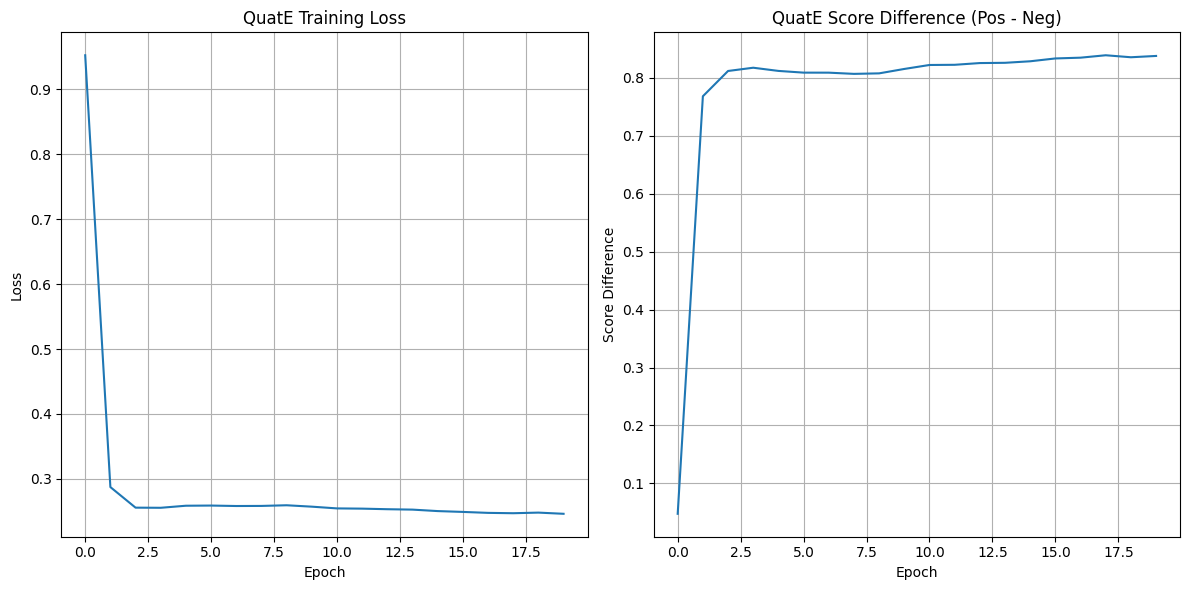

In [ ]:
def main(tokenized_examples, labels, vocabulary, inverse_vocabulary, run_full_training=True):
    """
    Main function to implement and evaluate QuatE model on knowledge graph dataset.
    
    Parameters:
    -----------
    tokenized_examples : numpy.ndarray
        The tokenized examples from your dataset
    labels : numpy.ndarray
        Binary labels (1 for positive, 0 for negative examples)
    vocabulary : dict
        Mapping from tokens to indices
    inverse_vocabulary : dict
        Mapping from indices to tokens
    run_full_training : bool
        Whether to run the full training process or just diagnostics
    
    Returns:
    --------
    results : dict
        Dictionary containing model, training metrics, and evaluation results
    """
    import jax
    import jax.numpy as jnp
    import numpy as np
    import equinox as eqx
    import optax
    import matplotlib.pyplot as plt
    from collections import defaultdict
    import time
    
    print("=== QuatE Model Implementation and Evaluation ===\n")
    
    # Step 1: Dataset Inspection (same as before)
    print("Step 1: Inspecting dataset...")
    
    # Extract entities and relations from the dataset
    entity_ids = set()
    relation_ids = set()
    entity_tokens = set()
    relation_tokens = set()
    
    for example in tokenized_examples:
        head_id = example[2]
        rel_id = example[4]
        tail_id = example[6]
        
        entity_ids.update([head_id, tail_id])
        relation_ids.add(rel_id)
        
        head_token = inverse_vocabulary.get(head_id, "[UNK]")
        rel_token = inverse_vocabulary.get(rel_id, "[UNK]")
        tail_token = inverse_vocabulary.get(tail_id, "[UNK]")
        
        entity_tokens.update([head_token, tail_token])
        relation_tokens.add(rel_token)
    
    # Basic dataset statistics
    num_entities = len(entity_ids)
    num_relations = len(relation_ids)
    max_entity_id = max(entity_ids)
    max_relation_id = max(relation_ids)
    
    print(f"Dataset statistics:")
    print(f"- Total examples: {len(tokenized_examples)}")
    print(f"- Positive examples: {np.sum(labels == 1)}")
    print(f"- Negative examples: {np.sum(labels == 0)}")
    print(f"- Unique entities: {num_entities}")
    print(f"- Unique relations: {num_relations}")
    print(f"- Max entity ID: {max_entity_id}")
    print(f"- Max relation ID: {max_relation_id}")
    
    # Sample examples (same as before)
    print("\nSample examples:")
    for i in range(min(5, len(tokenized_examples))):
        example = tokenized_examples[i]
        head_id = example[2]
        rel_id = example[4]
        tail_id = example[6]
        
        head_token = inverse_vocabulary.get(head_id, "[UNK]")
        rel_token = inverse_vocabulary.get(rel_id, "[UNK]")
        tail_token = inverse_vocabulary.get(tail_id, "[UNK]")
        
        print(f"Example {i+1}, Label: {labels[i]}")
        print(f"  Triple: ({head_token}, {rel_token}, {tail_token})")
        print(f"  IDs: ({head_id}, {rel_id}, {tail_id})")
    
    # Step 2: Analyze triples for patterns (same as before)
    print("\nStep 2: Analyzing triples for patterns...")
    
    # Extract all positive triples
    pos_indices = np.where(labels == 1)[0]
    positive_triples = []
    
    for idx in pos_indices:
        example = tokenized_examples[idx]
        head_id = example[2]
        rel_id = example[4]
        tail_id = example[6]
        positive_triples.append((head_id, rel_id, tail_id))
    
    # Count relation frequencies
    relation_counts = defaultdict(int)
    for _, r, _ in positive_triples:
        relation_counts[r] += 1
    
    print("\nRelation frequencies:")
    for rel_id, count in sorted(relation_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
        rel_token = inverse_vocabulary.get(rel_id, "[UNK]")
        print(f"  {rel_token} (ID: {rel_id}): {count} occurrences")
    
    # Check for symmetric relations
    symmetric_candidates = defaultdict(list)
    
    for h, r, t in positive_triples:
        # Check if (t, r, h) also exists
        symmetric_candidates[r].append((h, t))
    
    symmetric_relations = []
    for r, pairs in symmetric_candidates.items():
        symmetric_count = 0
        for h, t in pairs:
            if (t, h) in pairs:
                symmetric_count += 1
        
        if symmetric_count > 0:
            symmetric_percentage = symmetric_count / len(pairs) * 100
            if symmetric_percentage > 10:  # If more than 10% of pairs are symmetric
                rel_token = inverse_vocabulary.get(r, "[UNK]")
                symmetric_relations.append((r, rel_token, symmetric_percentage))
    
    if symmetric_relations:
        print("\nPotentially symmetric relations detected:")
        for r, token, percentage in symmetric_relations:
            print(f"  {token} (ID: {r}): {percentage:.1f}% of pairs are symmetric")
    else:
        print("\nNo strongly symmetric relations detected.")
    
    # Step 3: Implement QuatE model
    print("\nStep 3: Implementing QuatE model...")
    
    # Quaternion operations
    def quaternion_multiplication(a, b):
        """
        Compute the Hamilton product of two quaternions.
        Each quaternion is represented as a vector [a_1, a_2, a_3, a_4].
        """
        a_1, a_2, a_3, a_4 = a
        b_1, b_2, b_3, b_4 = b
        
        # Hamilton product formula
        c_1 = a_1 * b_1 - a_2 * b_2 - a_3 * b_3 - a_4 * b_4
        c_2 = a_1 * b_2 + a_2 * b_1 + a_3 * b_4 - a_4 * b_3
        c_3 = a_1 * b_3 - a_2 * b_4 + a_3 * b_1 + a_4 * b_2
        c_4 = a_1 * b_4 + a_2 * b_3 - a_3 * b_2 + a_4 * b_1
        
        return jnp.array([c_1, c_2, c_3, c_4])
    
    def quaternion_inner_product(a, b):
        """
        Compute the inner product of two quaternions.
        """
        return jnp.sum(a * b)
    
    def normalize_quaternion(q):
        """
        Normalize a quaternion to unit norm.
        """
        norm = jnp.sqrt(jnp.sum(q**2) + 1e-10)
        return q / norm
    
    class QuatE(eqx.Module):
        entity_embeds: jnp.ndarray  # Shape: [num_entities, 4, embed_dim//4]
        relation_embeds: jnp.ndarray  # Shape: [num_relations, 4, embed_dim//4]
        
        def __init__(self, num_entities, num_relations, embed_dim, key, init_scale=0.1):
            if embed_dim % 4 != 0:
                raise ValueError("Embedding dimension must be divisible by 4 for quaternion embeddings")
            
            # Dimension of each component of the quaternion
            quat_dim = embed_dim // 4
            
            entity_key, relation_key = jax.random.split(key)
            
            # Initialize entity embeddings
            entity_std = jnp.sqrt(6.0 / (num_entities + embed_dim)) * init_scale
            entity_embeds = jax.random.uniform(
                entity_key, 
                (num_entities, 4, quat_dim),
                minval=-entity_std,
                maxval=entity_std
            )
            
            # Initialize relation embeddings
            relation_std = jnp.sqrt(6.0 / (num_relations + embed_dim)) * init_scale
            relation_embeds = jax.random.uniform(
                relation_key,
                (num_relations, 4, quat_dim),
                minval=-relation_std,
                maxval=relation_std
            )
            
            # Normalize entity embeddings
            entity_norms = jnp.sqrt(jnp.sum(entity_embeds**2, axis=(1,2), keepdims=True) + 1e-10)
            self.entity_embeds = entity_embeds / entity_norms
            
            # Normalize relation embeddings
            relation_norms = jnp.sqrt(jnp.sum(relation_embeds**2, axis=(1,2), keepdims=True) + 1e-10)
            self.relation_embeds = relation_embeds / relation_norms
        
        def __call__(self, token_ids):
            """Score a triple using QuatE scoring function."""
            head_id = token_ids[2]
            rel_id = token_ids[4]
            tail_id = token_ids[6]
            
            head_emb = self.entity_embeds[head_id]  # Shape: [4, quat_dim]
            rel_emb = self.relation_embeds[rel_id]  # Shape: [4, quat_dim]
            tail_emb = self.entity_embeds[tail_id]  # Shape: [4, quat_dim]
            
            # Compute quaternion score across each component dimension
            quat_dim = head_emb.shape[1]
            scores = []
            
            for i in range(quat_dim):
                # Extract quaternion components for this dimension
                h_quat = head_emb[:, i]  # Shape: [4]
                r_quat = rel_emb[:, i]   # Shape: [4]
                t_quat = tail_emb[:, i]  # Shape: [4]
                
                # Normalize relation quaternion
                r_quat = normalize_quaternion(r_quat)
                
                # Compute h ⊗ r (quaternion multiplication)
                hr_quat = quaternion_multiplication(h_quat, r_quat)
                
                # Compute inner product between hr and t
                score_i = quaternion_inner_product(hr_quat, t_quat)
                scores.append(score_i)
            
            # Sum scores across all dimensions
            final_score = jnp.sum(jnp.array(scores))
            
            return final_score
    
    # Step 4: Improved negative sampling (same as before)
    print("\nStep 4: Creating improved negative samples...")
    
    def create_better_negatives(examples, labels, entity_ids, relation_ids):
        """Create more diverse negative examples."""
        pos_indices = np.where(labels == 1)[0]
        entity_list = list(entity_ids)
        relation_list = list(relation_ids)
        
        new_examples = []
        new_labels = []
        
        # Keep positive examples
        for idx in pos_indices:
            new_examples.append(examples[idx])
            new_labels.append(1)
        
        # Create diverse negatives
        for i, idx in enumerate(pos_indices):
            example = examples[idx].copy()
            strategy = i % 3  # Cycle through strategies
            
            if strategy == 0:
                # Replace head with random entity
                current_head = example[2]
                new_head = np.random.choice([e for e in entity_list if e != current_head])
                example[2] = new_head
            elif strategy == 1:
                # Replace tail with random entity
                current_tail = example[6]
                new_tail = np.random.choice([e for e in entity_list if e != current_tail])
                example[6] = new_tail
            else:
                # Replace relation with random relation
                current_rel = example[4]
                if len(relation_list) > 1:  # Only if we have other relations to choose from
                    new_rel = np.random.choice([r for r in relation_list if r != current_rel])
                    example[4] = new_rel
                else:
                    # Fallback to replacing tail if only one relation exists
                    current_tail = example[6]
                    new_tail = np.random.choice([e for e in entity_list if e != current_tail])
                    example[6] = new_tail
            
            new_examples.append(example)
            new_labels.append(0)
        
        # Convert to arrays and shuffle
        new_examples = np.array(new_examples)
        new_labels = np.array(new_labels)
        
        # Shuffle
        indices = np.random.permutation(len(new_examples))
        return new_examples[indices], new_labels[indices]
    
    # Create improved dataset
    if run_full_training:
        improved_examples, improved_labels = create_better_negatives(
            tokenized_examples, labels, entity_ids, relation_ids
        )
        
        print(f"Created new dataset with {len(improved_examples)} examples")
        print(f"- Positive examples: {np.sum(improved_labels == 1)}")
        print(f"- Negative examples: {np.sum(improved_labels == 0)}")
        
        # Step 5: Train QuatE model
        print("\nStep 5: Training QuatE model...")
        
        def train_quate_model(model, examples, labels, batch_size=64, num_epochs=20, learning_rate=0.01):
            """Train the QuatE model."""
            # Create optimizer
            schedule = optax.warmup_cosine_decay_schedule(
                init_value=0.0,
                peak_value=learning_rate,
                warmup_steps=100,
                decay_steps=5000,
                end_value=learning_rate/10
            )
            
            optimizer = optax.chain(
                optax.clip_by_global_norm(1.0),  # Gradient clipping
                optax.adam(learning_rate=schedule)
            )
            
            opt_state = optimizer.init(model)
            
            # Training variables
            pos_indices = np.where(labels == 1)[0]
            neg_indices = np.where(labels == 0)[0]
            
            all_losses = []
            all_score_diffs = []
            
            @eqx.filter_jit
            def train_step(model, opt_state, pos_batch, neg_batch):
                """Single training step with JAX JIT."""
                def loss_fn(model):
                    # Score positive and negative examples
                    pos_scores = jax.vmap(model)(pos_batch)
                    neg_scores = jax.vmap(model)(neg_batch)
                    
                    # Margin loss
                    margin = 1.0
                    basic_loss = jnp.mean(jnp.maximum(0, margin - (pos_scores - neg_scores)))
                    
                    # L2 regularization on embeddings
                    l2_reg = 0.01 * (
                        jnp.mean(model.entity_embeds**2) + 
                        jnp.mean(model.relation_embeds**2)
                    )
                    
                    return basic_loss + l2_reg
                
                # Compute gradients
                loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
                
                # Update model
                updates, new_opt_state = optimizer.update(grads, opt_state, model)
                new_model = eqx.apply_updates(model, updates)
                
                # Re-normalize entity embeddings
                entity_norms = jnp.sqrt(jnp.sum(new_model.entity_embeds**2, axis=(1,2), keepdims=True) + 1e-10)
                normalized_embeds = new_model.entity_embeds / entity_norms
                
                # Update model with normalized embeddings
                new_model = eqx.tree_at(
                    lambda m: m.entity_embeds,
                    new_model,
                    normalized_embeds
                )
                
                # Renormalize relation embeddings
                relation_norms = jnp.sqrt(jnp.sum(new_model.relation_embeds**2, axis=(1,2), keepdims=True) + 1e-10)
                normalized_relations = new_model.relation_embeds / relation_norms
                
                new_model = eqx.tree_at(
                    lambda m: m.relation_embeds,
                    new_model,
                    normalized_relations
                )
                
                # Calculate score difference for monitoring
                pos_scores = jax.vmap(model)(pos_batch)
                neg_scores = jax.vmap(model)(neg_batch)
                score_diff = jnp.mean(pos_scores - neg_scores)
                
                return new_model, new_opt_state, loss, score_diff
            
            # Training loop
            start_time = time.time()
            
            for epoch in range(num_epochs):
                # Shuffle indices
                pos_perm = np.random.permutation(len(pos_indices))
                neg_perm = np.random.permutation(len(neg_indices))
                
                epoch_losses = []
                epoch_score_diffs = []
                
                n_batches = min(len(pos_indices), len(neg_indices)) // batch_size
                
                for i in range(n_batches):
                    # Get batch indices
                    pos_batch_idx = pos_indices[pos_perm[i*batch_size:(i+1)*batch_size]]
                    neg_batch_idx = neg_indices[neg_perm[i*batch_size:(i+1)*batch_size]]
                    
                    # Get batch data
                    pos_batch = examples[pos_batch_idx]
                    neg_batch = examples[neg_batch_idx]
                    
                    # Training step
                    model, opt_state, loss, score_diff = train_step(
                        model, opt_state, pos_batch, neg_batch
                    )
                    
                    epoch_losses.append(loss)
                    epoch_score_diffs.append(score_diff)
                    
                    if i % 20 == 0:
                        print(f"Epoch {epoch+1}, Batch {i}: Loss = {loss:.4f}, Score Diff = {score_diff:.4f}")
                
                # Epoch summary
                avg_loss = np.mean(epoch_losses)
                avg_score_diff = np.mean(epoch_score_diffs)
                
                all_losses.append(avg_loss)
                all_score_diffs.append(avg_score_diff)
                
                print(f"Epoch {epoch+1}/{num_epochs}: Avg Loss = {avg_loss:.4f}, "
                      f"Avg Score Diff = {avg_score_diff:.4f}, "
                      f"Time = {time.time() - start_time:.1f}s")
                
                # Early stopping if we're doing well
                if avg_score_diff > 2.0:
                    print("Early stopping - good separation achieved")
                    break
                
                # Reset timer for next epoch
                start_time = time.time()
            
            return model, all_losses, all_score_diffs
        
        # Create and train QuatE model
        print("\nTraining QuatE model")
        quate_model = QuatE(
            num_entities=max_entity_id + 1,
            num_relations=max_relation_id + 1,
            embed_dim=256,
            key=jax.random.PRNGKey(0)
        )
        
        quate_model, quate_losses, quate_score_diffs = train_quate_model(
            quate_model, improved_examples, improved_labels, 
            num_epochs=20
        )
        
        # Step 6: Evaluate model
        print("\nStep 6: Evaluating QuatE model...")
        
        # Create test set (use a 20% holdout)
        test_indices = np.random.choice(
            len(improved_examples), 
            size=int(0.2 * len(improved_examples)), 
            replace=False
        )
        
        test_examples = improved_examples[test_indices]
        test_labels = improved_labels[test_indices]
        
        def evaluate_model(model, examples, labels):
            """Evaluate model performance."""
            pos_indices = np.where(labels == 1)[0]
            neg_indices = np.where(labels == 0)[0]
            
            # Score all examples
            all_scores = []
            for i in range(len(examples)):
                score = model(examples[i])
                all_scores.append(score)
            
            all_scores = np.array(all_scores)
            
            # Get scores by label
            pos_scores = all_scores[pos_indices]
            neg_scores = all_scores[neg_indices]
            
            # Basic statistics
            avg_pos_score = np.mean(pos_scores)
            avg_neg_score = np.mean(neg_scores)
            score_diff = avg_pos_score - avg_neg_score
            
            # Find optimal threshold
            min_score = np.min(all_scores)
            max_score = np.max(all_scores)
            
            best_accuracy = 0
            best_threshold = 0
            
            # Try different thresholds
            thresholds = np.linspace(min_score, max_score, 100)
            for threshold in thresholds:
                predictions = all_scores > threshold
                accuracy = np.mean(predictions == labels)
                
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_threshold = threshold
            
            # Final metrics with best threshold
            predictions = all_scores > best_threshold
            accuracy = np.mean(predictions == labels)
            
            pos_correct = np.sum(predictions[pos_indices] == 1)
            neg_correct = np.sum(predictions[neg_indices] == 0)
            
            pos_accuracy = pos_correct / len(pos_indices)
            neg_accuracy = neg_correct / len(neg_indices)
            
            return {
                'avg_pos_score': avg_pos_score,
                'avg_neg_score': avg_neg_score,
                'score_diff': score_diff,
                'best_threshold': best_threshold,
                'accuracy': accuracy,
                'pos_accuracy': pos_accuracy,
                'neg_accuracy': neg_accuracy
            }
        
        # Evaluate QuatE model
        quate_results = evaluate_model(quate_model, test_examples, test_labels)
        
        print("\nQuatE Model Results:")
        print(f"  Average positive score: {quate_results['avg_pos_score']:.4f}")
        print(f"  Average negative score: {quate_results['avg_neg_score']:.4f}")
        print(f"  Score difference: {quate_results['score_diff']:.4f}")
        print(f"  Accuracy: {quate_results['accuracy']:.4f}")
        print(f"  Positive class accuracy: {quate_results['pos_accuracy']:.4f}")
        print(f"  Negative class accuracy: {quate_results['neg_accuracy']:.4f}")
        
        # Plot training progress
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(quate_losses)
        plt.title('QuatE Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(quate_score_diffs)
        plt.title('QuatE Score Difference (Pos - Neg)')
        plt.xlabel('Epoch')
        plt.ylabel('Score Difference')
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig('quate_results.png')
        
        # Return results dictionary
        results = {
            'quate_model': quate_model,
            'quate_metrics': {
                'losses': quate_losses,
                'score_diffs': quate_score_diffs,
                'evaluation': quate_results
            },
            'improved_examples': improved_examples,
            'improved_labels': improved_labels
        }
    else:
        # Only return diagnostics
        results = {
            'dataset_stats': {
                'num_examples': len(tokenized_examples),
                'num_pos': np.sum(labels == 1),
                'num_neg': np.sum(labels == 0),
                'num_entities': num_entities,
                'num_relations': num_relations
            }
        }
    
    print("\nQuatE implementation and evaluation complete!")
    return results

results = main(tokenized_examples, labels, vocabulary, inverse_vocabulary)